In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 1: Import Libraries & Load Data

In [1]:
# 📦 Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 📥 Load the data
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# 👀 Preview
train.shape, test.shape


((1460, 81), (1459, 80))

# View the first few rows#

In [2]:
# View first few rows of training data
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Check how many missing values we have per column (only >0)

In [6]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


# 🔧 Step 2: Handle Missing Values

# A. Drop Columns with Excessive Missing Values 

In [7]:
drop_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)


# B. Fill Missing Categorical Features with 'None'

In [9]:
fill_none_cols = [
    'MasVnrType', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual'
]

for col in fill_none_cols:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')


# C. Fill Numeric Columns with 0 Where Appropriate

In [11]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)


# D. Impute LotFrontage Using Neighborhood Median

In [12]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))


# E. Fill 'Electrical' with Mode (only one missing)

In [14]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])



# Checking for missing values

In [15]:
train.isnull().sum().sort_values(ascending=False).head(10)


Id              0
HalfBath        0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
FullBath        0
dtype: int64

In [17]:
train.isnull().sum().sort_values(ascending=False).head(20)


Id              0
HalfBath        0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
FullBath        0
HeatingQC       0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
Electrical      0
GarageType      0
GarageYrBlt     0
dtype: int64

In [18]:
test.isnull().sum().sort_values(ascending=False).head(20)

MSZoning        4
BsmtHalfBath    2
Functional      2
BsmtFullBath    2
Utilities       2
BsmtFinSF1      1
Exterior1st     1
KitchenQual     1
GarageCars      1
GarageArea      1
Exterior2nd     1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
SaleType        1
Fireplaces      0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
dtype: int64

# Handle missing values in the test set

In [20]:
# Fill categorical columns with mode (assign directly)
test['MSZoning']     = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['Functional']   = test['Functional'].fillna(test['Functional'].mode()[0])
test['Utilities']    = test['Utilities'].fillna(test['Utilities'].mode()[0])
test['Exterior1st']  = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd']  = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['KitchenQual']  = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['SaleType']     = test['SaleType'].fillna(test['SaleType'].mode()[0])

# Fill numerical columns with median (use assignment)
num_cols = ['BsmtHalfBath', 'BsmtFullBath', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']

for col in num_cols:
    test[col] = test[col].fillna(test[col].median())


In [22]:
test.isnull().sum().sum()


0

#  Encode Categorical Features

In [24]:
df = train.copy()
# Select object (categorical) columns
cat_cols = df.select_dtypes(include='object').columns
cat_cols


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

# Check which categorical columns have missing values

In [25]:
# Check which categorical columns have missing values
df[cat_cols].isnull().sum().sort_values(ascending=False).head(20)


MSZoning        0
KitchenQual     0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Heating         0
HeatingQC       0
CentralAir      0
Electrical      0
Functional      0
BsmtQual        0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PavedDrive      0
SaleType        0
BsmtCond        0
Foundation      0
dtype: int64

In [26]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.shape


(1460, 248)

# Linear Regression: Model Training and Evaluation
In this section, we train a Linear Regression model using scikit-learn to predict house sale prices. We evaluate the model using Root Mean Squared Error (RMSE) and R-squared (R²) metrics.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Separate features (X) and target (y)
X = df_encoded.drop('SalePrice', axis=1)
y = df_encoded['SalePrice']

# 2. Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 4. Predict on the test set
y_pred = lr_model.predict(X_test)

# 5. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")


Root Mean Squared Error (RMSE): 52438.57
R-squared (R²): 0.6415


## Random Forest Regressor


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R-squared (R²): {r2_rf:.4f}")


Root Mean Squared Error (RMSE): 28832.35
R-squared (R²): 0.8916


## Random Forest Regressor

To improve upon the performance of Linear Regression, we trained a **Random Forest Regressor** using 100 estimators.

- **Root Mean Squared Error (RMSE):** 28,832.35  
- **R-squared (R²):** 0.8916

These metrics show a **significant improvement** over Linear Regression:
- RMSE decreased from ~52,438 to ~28,832 (lower is better),
- R² increased from 0.6415 to 0.8916 (closer to 1 is better).

This indicates that the Random Forest model captures complex patterns and performs better at predicting house prices.


### XGBoost Regressor
We now train an XGBoost regressor, which often performs well on structured tabular data. It supports regularization and handles complex feature interactions better than linear models

In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R²): {r2_xgb:.4f}")


Root Mean Squared Error (RMSE): 26123.49
R-squared (R²): 0.9110


# Grid Search for Hyperparameter Optimization
To further enhance model performance, we use GridSearchCV to exhaustively search over a defined set of key hyperparameters. This method evaluates all possible combinations of parameter values using cross-validation, helping us identify the configuration that yields the best predictive accuracy.

In [30]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


# Grid Search with XGBoost Regressor
We apply GridSearchCV to fine-tune the hyperparameters of the XGBRegressor. This method performs an exhaustive search over a specified parameter grid using 5-fold cross-validation. The evaluation metric used is negative root mean squared error (neg_root_mean_squared_error), and parallel processing is enabled to speed up the search.

In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

# Evaluate the Best XGBoost Model
After performing the grid search, we retrieve the best model and evaluate its performance on the test set using Root Mean Squared Error (RMSE) and R-squared (R²).

In [32]:
best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Tuned RMSE:", rmse)
print("Tuned R²:", r2)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Tuned RMSE: 26764.919756769024
Tuned R²: 0.9066061976718732


# Model Performance on Test Set:
RMSE: 26,764.92

R² Score: 0.9066

These metrics suggest the model fits the data well, explaining over 90% of the variance in the target variable.

# Hyperparameter Tuning with RandomizedSearchCV
To optimize the performance of the XGBoost model, we perform hyperparameter tuning using RandomizedSearchCV. This approach searches through a random combination of parameters, which is more efficient than grid search when exploring a large parameter space.

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

# Fitting the Best XGBoost Model with Early Stopping
After performing RandomizedSearchCV, we extract the best model using .best_estimator_. We then refit this model on the training data and evaluate it on the test set using early stopping, which halts training if the validation score does not improve for 10 consecutive rounds.

In [39]:
best_model = random_search.best_estimator_


In [40]:
best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)


[0]	validation_0-rmse:81404.31630
[1]	validation_0-rmse:76071.09503
[2]	validation_0-rmse:71478.06530
[3]	validation_0-rmse:66855.82627
[4]	validation_0-rmse:62230.92949
[5]	validation_0-rmse:58494.16989
[6]	validation_0-rmse:55687.63505
[7]	validation_0-rmse:52274.82254
[8]	validation_0-rmse:49846.00571
[9]	validation_0-rmse:47616.90261
[10]	validation_0-rmse:45296.36362
[11]	validation_0-rmse:43386.84081
[12]	validation_0-rmse:41419.60982
[13]	validation_0-rmse:39844.85971
[14]	validation_0-rmse:38508.04170
[15]	validation_0-rmse:36935.84207
[16]	validation_0-rmse:36276.81477
[17]	validation_0-rmse:35131.39725
[18]	validation_0-rmse:34448.26585
[19]	validation_0-rmse:33580.07153
[20]	validation_0-rmse:32703.98153
[21]	validation_0-rmse:32048.79930
[22]	validation_0-rmse:31635.54107
[23]	validation_0-rmse:31183.32363
[24]	validation_0-rmse:30744.60516
[25]	validation_0-rmse:30381.09146
[26]	validation_0-rmse:30007.47613
[27]	validation_0-rmse:29684.64125
[28]	validation_0-rmse:29437.6

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:27911.58270
[34]	validation_0-rmse:27755.34013
[35]	validation_0-rmse:27541.72189
[36]	validation_0-rmse:27240.17277
[37]	validation_0-rmse:27145.78872
[38]	validation_0-rmse:26821.18802
[39]	validation_0-rmse:26627.74822
[40]	validation_0-rmse:26630.71882
[41]	validation_0-rmse:26641.90130
[42]	validation_0-rmse:26522.08598
[43]	validation_0-rmse:26415.47628
[44]	validation_0-rmse:26102.48454
[45]	validation_0-rmse:26008.09101
[46]	validation_0-rmse:26014.03644
[47]	validation_0-rmse:26029.34581
[48]	validation_0-rmse:25934.05728
[49]	validation_0-rmse:25774.83249
[50]	validation_0-rmse:25683.15658
[51]	validation_0-rmse:25649.06988
[52]	validation_0-rmse:25677.91061
[53]	validation_0-rmse:25677.49983
[54]	validation_0-rmse:25678.91417
[55]	validation_0-rmse:25711.14009
[56]	validation_0-rmse:25740.74897
[57]	validation_0-rmse:25667.47836
[58]	validation_0-rmse:25543.31171
[59]	validation_0-rmse:25573.77079
[60]	validation_0-rmse:25572.06964
[61]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
{
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0.2,
    'subsample': 0.8,
    'n_estimators': 300
}


{'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'gamma': 0.2,
 'subsample': 0.8,
 'n_estimators': 300}

# Final Model Evaluation on Test Set
After training the best model with early stopping, we evaluate its performance on the test set using two key regression metrics:

Root Mean Squared Error (RMSE): Measures the average magnitude of the prediction error. Lower values indicate better performance.

R² Score (Coefficient of Determination): Represents the proportion of variance in the target variable explained by the model. A value closer to 1.0 indicates a better fit.

In [42]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")


Test RMSE: 24802.49
Test R²: 0.9198


# Results:

Test RMSE: 24,802.49

Test R²: 0.9198

These results show that the tuned XGBoost model performs well on unseen data, capturing over 91% of the variance in the target variable.

# Visualizing Validation RMSE Over Boosting Rounds
To gain insight into how the model’s performance evolved during training, we can visualize the validation RMSE over each boosting round. This helps confirm whether early stopping successfully prevented overfitting.

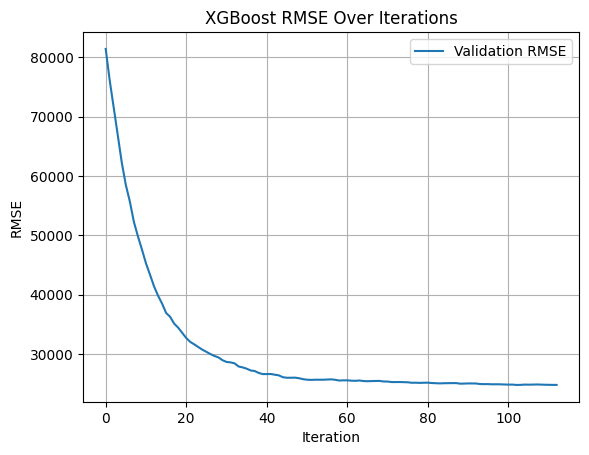

In [43]:
import matplotlib.pyplot as plt

results = best_model.evals_result()
rmse_vals = results['validation_0']['rmse']

plt.plot(rmse_vals, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


# Saving the model

In [44]:
import joblib
joblib.dump(best_model, 'xgboost_tuned_model.pkl')


['xgboost_tuned_model.pkl']